In [223]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns
%matplotlib inline

import itertools

# 데이터 불러오기

In [224]:
house_df = pd.read_csv("household_power_consumption.csv").loc[:10000]
house_df["datetime"] = house_df["datetime"].astype("datetime64")
house_df.head(3)

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666


In [225]:
data = house_df[["datetime", "Voltage"]].set_index("datetime")
data.head(3)

,Voltage
datetime,
2006-12-16 17:24:00,234.84
2006-12-16 17:25:00,233.63
2006-12-16 17:26:00,233.29


In [226]:
data.isnull().sum()

Voltage    0
dtype: int64

# 질문
해당 데이터(Voltage)는 추세가 없고 <br>
계절성만 띄고 있는 데이터인가요?

만약 그렇다면, 차분을 하지 않고 계절성 분해만 진행하면 되는건가요?

<AxesSubplot:xlabel='datetime'>

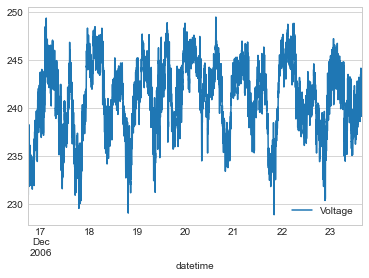

In [227]:
data.plot()

# 데이터 전처리

## additive model(계절)

# 질문

period 인자가 의미하는 바를 모르겠습니다.<br>
(period 안 넣으면 오류 떠요.)

<period 인자 설명>
x가 판다스 객체가 아니거나 x의 index에 freq를 가지고 있지 않다면 period를 써줘야합니다.
x가 타임시리즈 인덱스를 가진 판다스 객체라면 default를 재정의 해줘야합니다.

period 사용이유는 코드적으로는 이해했으나, 함수 내에서 period가 그래프에서 어떤 의미를 갖고 있는지 잘 모르겠습니다.

In [228]:
pd.date_range('2021-02-01', periods=14)

DatetimeIndex(['2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04',
               '2021-02-05', '2021-02-06', '2021-02-07', '2021-02-08',
               '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12',
               '2021-02-13', '2021-02-14'],
              dtype='datetime64[ns]', freq='D')

In [229]:
data.index

DatetimeIndex(['2006-12-16 17:24:00', '2006-12-16 17:25:00',
               '2006-12-16 17:26:00', '2006-12-16 17:27:00',
               '2006-12-16 17:28:00', '2006-12-16 17:29:00',
               '2006-12-16 17:30:00', '2006-12-16 17:31:00',
               '2006-12-16 17:32:00', '2006-12-16 17:33:00',
               ...
               '2006-12-23 15:55:00', '2006-12-23 15:56:00',
               '2006-12-23 15:57:00', '2006-12-23 15:58:00',
               '2006-12-23 15:59:00', '2006-12-23 16:00:00',
               '2006-12-23 16:01:00', '2006-12-23 16:02:00',
               '2006-12-23 16:03:00', '2006-12-23 16:04:00'],
              dtype='datetime64[ns]', name='datetime', length=10001, freq=None)

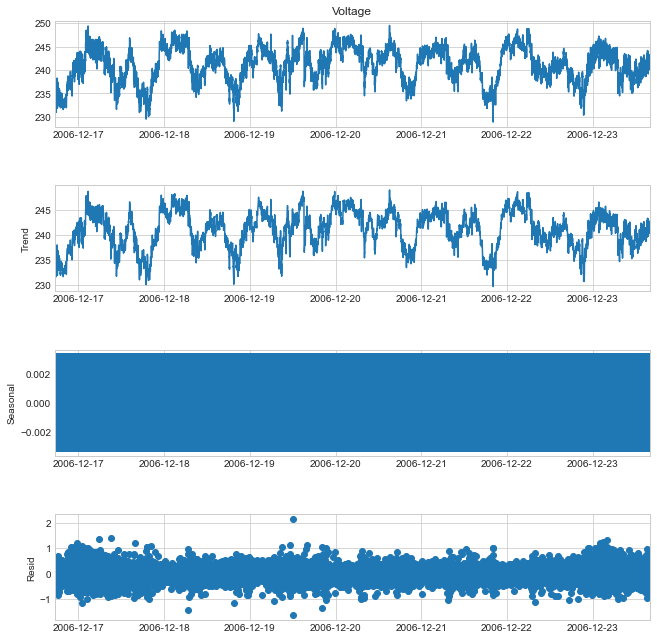

In [230]:
decomposition = sm.tsa.seasonal_decompose(data["Voltage"],
                                         period=2,
                                         model="additive")

fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

In [231]:
# decomposition = sm.tsa.seasonal_decompose(data["Voltage"],
#                                          period=5,
#                                          model="multiplicative")

# fig = decomposition.plot()
# # plt.figure(figsize=(16, 12))
# fig.set_size_inches(10, 10)
# plt.show()

# 추세 성분 분해

In [232]:
decomposition.trend.dropna()

datetime
2006-12-16 17:25:00    233.8475
2006-12-16 17:26:00    233.4875
2006-12-16 17:27:00    234.1125
2006-12-16 17:28:00    235.0300
2006-12-16 17:29:00    235.2025
                         ...   
2006-12-23 15:59:00    241.6300
2006-12-23 16:00:00    241.2850
2006-12-23 16:01:00    240.9675
2006-12-23 16:02:00    240.7875
2006-12-23 16:03:00    241.1625
Name: trend, Length: 9999, dtype: float64

<AxesSubplot:xlabel='datetime'>

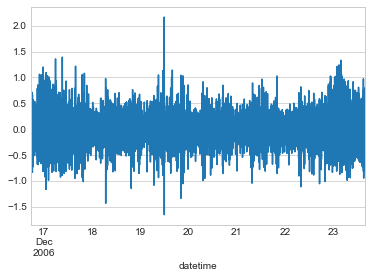

In [233]:
## detrend
(data['Voltage'] - decomposition.trend).plot()
# decomposition.trend.plot()

<AxesSubplot:xlabel='datetime'>

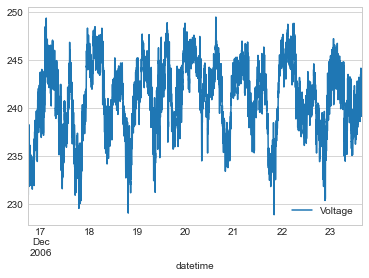

In [234]:
data.plot()

# 계절 성분 분해

# 질문
분산이 안정화가 되지 않는 것 같습니다.
애초에 기존 그래프가 분산이 안정적인 그래프인건가요?

<AxesSubplot:xlabel='datetime'>

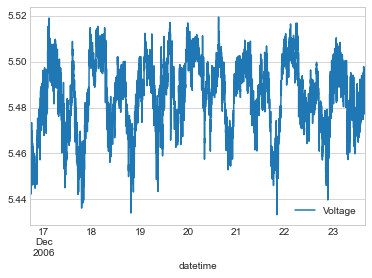

In [216]:
import numpy as np

# 로그를 취하여 분산을 안정화
log_data = np.log(data.copy())
log_data.plot()

<AxesSubplot:xlabel='datetime'>

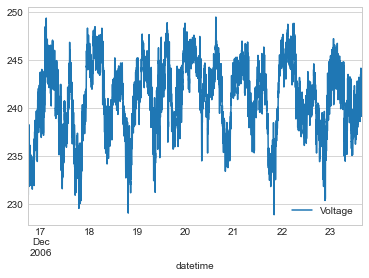

In [217]:
data.plot()

# ACF, PACF TEST(자기상관함수)
- 정상계열은 빠르게 0으로 내려갑니다.<br>
  약한 정상의 경우 분산이 시차에 따라 변하기 때문에
  
- 비정상 계열의 ACF는 천천히 감소하며, 큰 값을 가지는 경우가 많습니다.


In [218]:
# split => 시계열에서는 다르게 => shuffle=False
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

/opt/homebrew/Caskroom/miniforge/base/envs/nano/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


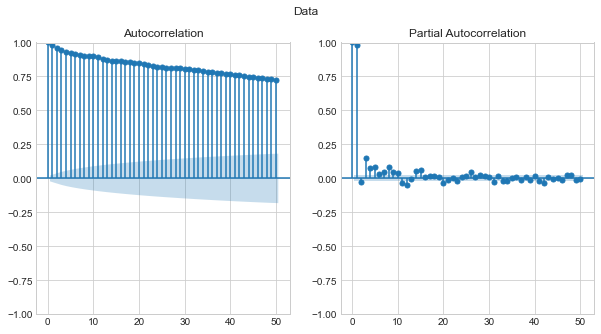

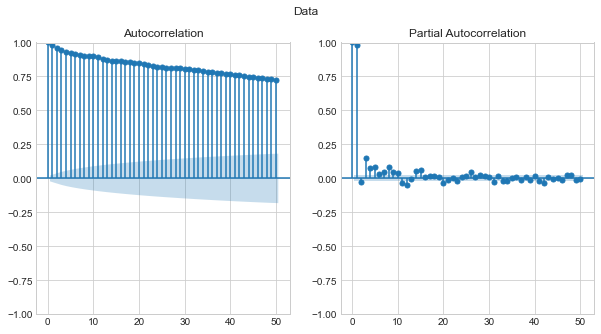

In [220]:
# 빠르게 값을 내려가야 정상
# 그렇지 않다면, 잘 안되고 있는 것
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Data')

sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=50, ax=ax[1])